## Assignment 8 Submission

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import stats

### Q1

In Q1, the diabetes dataset is used for predicting whether the patients have diabetes or not. The data is taken from kaggle (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset).

In [ ]:
df = pd.read_csv("./../diabetes_prediction_dataset.csv")

# Cleaning the dataset
df = df.drop(["smoking_history"], axis = 1)
df["gender"] = pd.factorize(df["gender"])[0] # 0 female, 1 male, 2 other

# Rescaling, otherwise the sample won't converged
df["age"] = (df["age"]-df["age"].mean()) / df["age"].std()
df["bmi"] = (df["bmi"]-df["bmi"].mean()) / df["bmi"].std()
df["HbA1c_level"] = (df["HbA1c_level"]-df["HbA1c_level"].mean()) / df["HbA1c_level"].std()
df["blood_glucose_level"] = (df["blood_glucose_level"]-df["blood_glucose_level"].mean()) / df["blood_glucose_level"].std()

df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.692695,0,1,-0.321054,1.001701,0.047704,0
1,0,0.538004,0,0,-0.000116,1.001701,-1.426203,0
2,1,-0.616688,0,0,-0.000116,0.161107,0.489876,0
3,0,-0.261398,0,0,-0.583229,-0.492688,0.416181,0
4,1,1.515050,1,1,-1.081965,-0.679486,0.416181,0


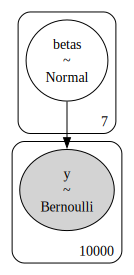

In [ ]:
df = df.sample(frac = 0.1) # 100k data is too big
y_obs = df["diabetes"].to_numpy() # output

df2 = df.drop("diabetes", axis = 1)
X = df2.to_numpy()
n, p = len(X), len(X[0])

with pm.Model() as bayes_logit:
    betas = pm.Normal("betas", mu = 0, sigma = 1, shape = p)
    y = pm.Bernoulli("y", p = pm.math.sigmoid(X@betas), observed = y_obs)
pm.model_to_graphviz(bayes_logit)

In [91]:
with bayes_logit:
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


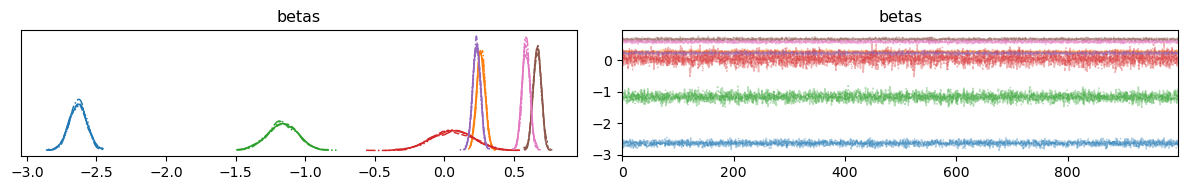

In [92]:
az.plot_trace(idata)
plt.tight_layout()

In [93]:
az.summary(idata, round_to = 5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-2.63340,0.06254,-2.74897,-2.51558,0.00092,0.00065,4566.47841,3423.76934,1.00084
betas[1],0.26241,0.02932,0.20445,0.31415,0.00045,0.00032,4262.98929,3106.17417,0.99953
betas[2],-1.16447,0.10866,-1.36763,-0.95785,0.00154,0.00109,4971.64901,3451.06339,0.99983
betas[3],0.05722,0.14719,-0.21740,0.32992,0.00229,0.00204,4140.53712,3164.41393,1.00051
betas[4],0.23053,0.02792,0.17560,0.28145,0.00039,0.00028,5059.52536,3223.26896,1.00000
betas[5],0.66668,0.02863,0.61502,0.72048,0.00044,0.00031,4255.88044,3170.04287,1.00087
betas[6],0.58570,0.02769,0.53014,0.63458,0.00038,0.00027,5182.15685,3292.22357,1.00107


<Axes: >

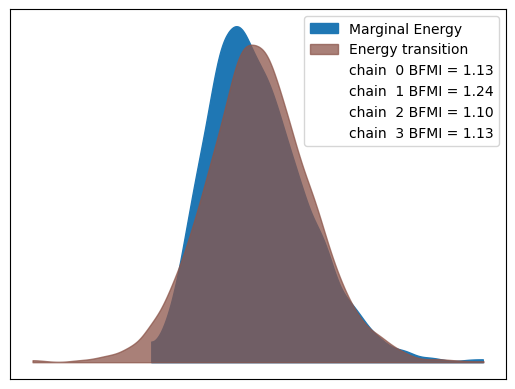

In [94]:
az.plot_energy(idata)

From the data, we use many features to predict the probability of having diabetes by using Bayesian logisitic regression. The code indicates that we removed some features out for simplicity, and only took 1% of the entire for faster computation. Therefore, the sample may not be the most accurate ones. Moreover, the data need to be rescaled so that the sample converged.

From the MCMC result summary, we can see that the regression coefficients are all significant to the model $\frac{\hat \beta_i}{se(\beta_i)}$ yields very high values except `beta[3]` (heart_disease column). The lower bound and upper bound of credible interval does not differ that much, indicates that the sample converge well with more than 4000 ESS, which is higher than the number of sample itself.

From the energy plot, the energy transition graph is slightly off the marginal energy graph. This indicates that there are some samples among the chain that might not agree with each other. This may happen because there are very few positive data (patients having diabetes) and we only pick 1% of them (which may not have any positive value in the worst case).

### Q2

In Q2, the energy efficient dataset is used, the dataset is obtained from the features of different building and the heating load and cooling load as outputs (https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset). We will use last $m$ columns to be an output

In [164]:
df = pd.read_csv("./../ENB2012_data.csv")
df = df.sample(n = 100, random_state=1234)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
200,0.86,588.0,294.0,147.0,7.0,2,0.10,4,26.44,27.17
40,0.64,784.0,343.0,220.5,3.5,2,0.00,0,10.85,16.78
630,0.90,563.5,318.5,122.5,7.0,4,0.40,3,35.05,33.82
356,0.76,661.5,416.5,122.5,7.0,2,0.25,2,36.95,36.87
305,0.79,637.0,343.0,147.0,7.0,3,0.25,1,40.03,37.81


In [165]:
X = df.iloc[:, :8].to_numpy()
Y = df.iloc[:, 8:]
n, m, p = len(df), 10-len(X[0]), len(X[0])
n, m, p

(100, 2, 8)

In [166]:
# beta_ = np.ones((p,m))
# X = stats.norm().rvs((n,p))
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
a_cov = Y.cov().to_numpy()
Y = Y.to_numpy()
# x = X@beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Output()

ValueError: Not enough samples to build a trace.

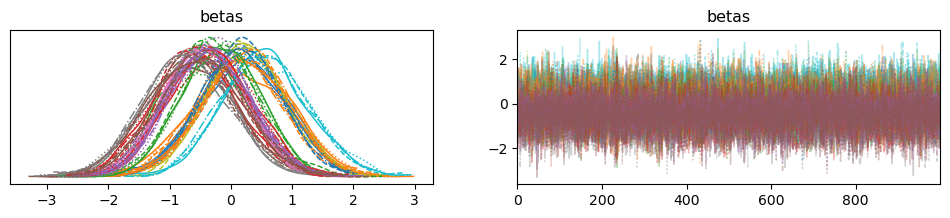

In [156]:
az.plot_trace(idata,var_names='betas');

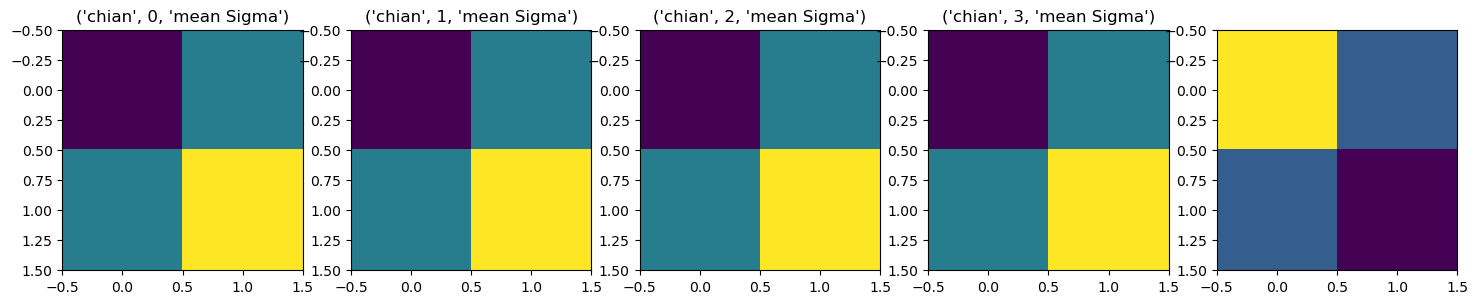

In [157]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))

### Q3

The dataset used in Q3 are adapted from https://www.kaggle.com/datasets/tumulgupta/2017-nyc-tlc-dataset, which contains the data about taxi fares.

In [ ]:
df = pd.read_csv("./../2017_Yellow_Taxi_Trip_Data.csv")